In [128]:
import time
import torch
import glob
import cv2
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [129]:
path_wiki = 'data/watches/ds3_crown/cleandata.csv'
path_imdb = 'data/watches/ds3_crown/images/'
img_size = 255

In [130]:
#Quelle nach der Anleitung von https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
class WatchDataset(Dataset):
    def __init__(self):
        df = pd.read_csv(path_wiki)
        
        self.imgs_path = df["image_name"]
        self.price = df["price"]
        
        self.data = []
        for index, row in df.iterrows():
            self.data.append([row["image_name"], row["price"]])
        
        self.img_dim = (img_size, img_size) #original Images 406x512 -> /7 = 
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, price = self.data[idx]
        img = cv2.imread(path_imdb + img_path)
        #print("Image Path: " + "data/watches/kaggle_data/images" + img_path)
        #print(img)
        img = cv2.resize(img, self.img_dim)
        
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = img_tensor.float()
        
        price = torch.tensor([price]) #unsicher ob man das überhaupt machen muss
        return img_tensor[0], price.float()

In [131]:
dataset = WatchDataset()

KeyboardInterrupt: 

In [ ]:
print(f" Width of one image is {len(dataset[0][0][0])}")

 Width of one image is 255


In [ ]:
print(f" Pictures in the Dataset: {len(dataset)}")

 Pictures in the Dataset: 26228


In [ ]:
def get_watch_inf_from_dataset(dataset_element):
    plt.imshow(dataset_element[0])
    print(f"Watch Price: {float(dataset_element[1][0])}")

Watch Price: 3250.0


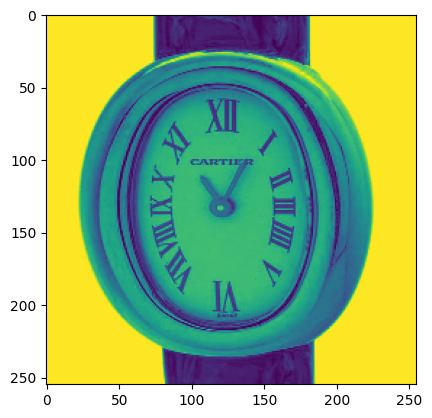

In [ ]:
get_watch_inf_from_dataset(dataset[0])

## Initialize and set up the NeuralNetwork

In the next codeblock I buld the neural newtork:

In [ ]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, hidden_features=10584):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(img_size * img_size, 10584),
            torch.nn.ReLU(),
            torch.nn.Linear(10584, 5000),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 2500),
            torch.nn.ReLU(),
            torch.nn.Linear(2500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1),
            #torch.nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Test the Neural Network with one single Image

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=1)

In [ ]:
NN = NeuralNetwork()
X, y = next(iter(train_dataloader))
print(f"Price of Watch: {y}")
print(f"Result from NN: {NN(X)}")
print(f"Batch length: {len(NN(X))}")
loss_fn = torch.nn.MSELoss()
print(f"Result from loss funktion: {loss_fn(NN(X), y)}")

Price of Watch: tensor([[3250.]])
Result from NN: tensor([[0.0788]], grad_fn=<AddmmBackward0>)
Batch length: 1
Result from loss funktion: 10561987.0


## Set calculation for R2 Metric

In [ ]:
def r_squared(y_pred, y_true):
    y_mean = torch.mean(y_true)
    ss_total = torch.sum((y_true - y_mean) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [ ]:
#from tqdm.contrib.discord import tqdm
#token = "{MTEyMjUwNTI3NDYxNjQ1OTM0NA.Gsd2hh.wZSPQcP5rNR9RFRnRBLfzWv0uVDIGtS0E4RU68}"

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cpu"):
    for X, y in dataloader:
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        #print(pred)
        #loss_fn = torch.nn.MSELoss()
        loss = loss_fn(pred, y)
        #print(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_div, r2 = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # Move data to device
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y)
            metric = torch.nn.L1Loss()
            correct_div += metric(pred, y)
            r2 += r_squared(pred, y)
            

    test_loss /= num_batches
    correct_div /= num_batches
    r2 /= num_batches
    #print(f"L1Loss: {correct_div:>0.1f}, Avg loss: {test_loss} , Pred: {pred}, Y: {y}")  #:>8f -> ") #
    print(f"L1Loss: {correct_div:>0.1f}, Avg loss: {test_loss}, R2: {r2} ")

In [ ]:
# Set Hyperparameter
LEARNING_RATE = 1e-9
BATCH_SIZE = 64
EPOCHS = 8

In [ ]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.0, 0.2])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# Init model and move to GPU
# Needlessly make the model more complex with large hidden-layer size
model = NeuralNetwork(hidden_features=2048) 
model.to(device)

# Define loss function and init optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Measure time for training
start_time = time.time()
print(f"Train on {device}")
for t in range(EPOCHS):
    print(f"Epoch {t+1} -------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print(f"Done in {time.time() - start_time:.2f}s!")

Train on cpu
Epoch 1 -------------------------------
L1Loss: 4929.9, Avg loss: 42744960.0, R2: -0.06148858368396759 
Epoch 2 -------------------------------
L1Loss: 4927.6, Avg loss: 42727344.0, R2: -0.06078282743692398 
Epoch 3 -------------------------------
L1Loss: 4924.5, Avg loss: 42704372.0, R2: -0.059859149158000946 
Epoch 4 -------------------------------
L1Loss: 4921.7, Avg loss: 42683528.0, R2: -0.059018541127443314 
Epoch 5 -------------------------------
L1Loss: 4918.7, Avg loss: 42661460.0, R2: -0.05812482163310051 
Epoch 6 -------------------------------
L1Loss: 4915.0, Avg loss: 42634308.0, R2: -0.05702073872089386 
Epoch 7 -------------------------------
L1Loss: 4912.0, Avg loss: 42612508.0, R2: -0.056129537522792816 
Epoch 8 -------------------------------


KeyboardInterrupt: 

In [ ]:
def get_model_prediction(dataloader, model, device):
    predictions = []
    real_values = []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        model_results = model(X)
        for pred in model_results:
            predictions.append(pred[0].item())
        for y_values in y:
            real_values.append(y_values.item())
    return predictions, real_values

In [ ]:
y_pred_train, y_train = get_model_prediction(train_dataloader, model, device)
y_pred, y_test = get_model_prediction(test_dataloader, model, device)

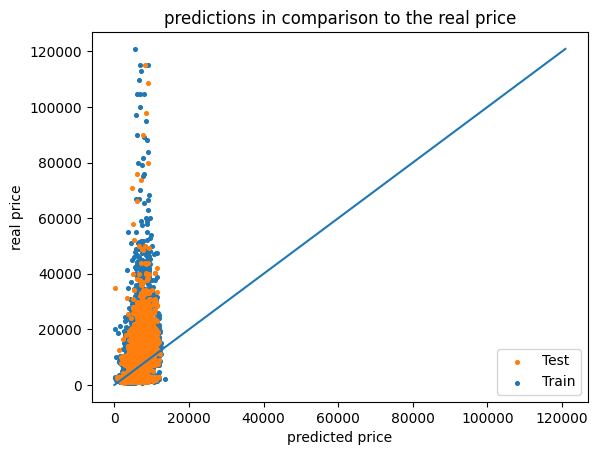

In [ ]:
fig, ax = plt.subplots()

train = ax.scatter(y_pred_train, y_train, s=7, label ="Train")
test = ax.scatter(y_pred, y_test, s=7, label= "Test")

ax.plot([0,max(y_train)], [0,max(y_train)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test, train], loc='lower right')

# plt.show()

In [ ]:
## save model to storage
with open("models/M2_NN_ds3.pickle", mode="wb") as out_file:
    pickle.dump(model, out_file)

Watch Price: 1750.0


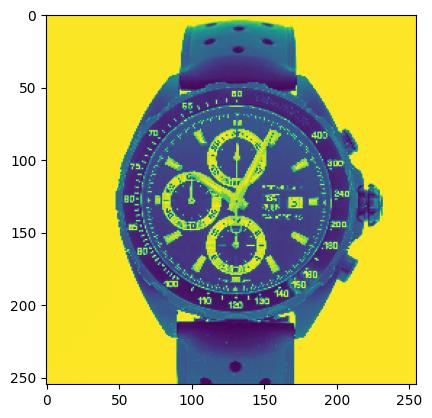

In [ ]:
get_watch_inf_from_dataset(dataset[3333])

In [ ]:
test_image = DataLoader(dataset, batch_size=1)

In [ ]:
X, y = next(iter(test_image))
print(f"Price of Watch: {y}")
print(f"Result from NN: {model(X)}")
print(f"Batch length: {len(model(X))}")
loss_fn = torch.nn.MSELoss()
print(f"Result from loss funktion: {loss_fn(model(X), y)}")

Price of Watch: tensor([[3250.]])
Result from NN: tensor([[9323.6318]], grad_fn=<AddmmBackward0>)
Batch length: 1
Result from loss funktion: 36889004.0
